Dictionary:
* Heuristic = Found using Viro's Patchworking Algorithm
* Correct = Found using a polynomial solving tool
* Approximation = Best fit line using heurtistic or correct data
* Expected = Plot of the formula proved for expectation of real zeros  

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.special import comb
from scipy.special import factorial
from scipy.optimize import curve_fit
from fractions import Fraction
import matplotlib.pyplot as plt

import os
import glob

# Ensemble Functions

Helper functions

In [ ]:
def product_AtoB(a, b):
    product = 1
    for i in range(a, b+1):
        product *= np.sqrt(i)
    return product

def new_flat_coeff(d, i):
    std_dev = np.sqrt(2*np.pi*d)
    for j in range(1,i+1):
        std_dev *= np.sqrt(d / (2 * np.e) / j)
    return std_dev

In [ ]:
#basic random number generator
#will need to be modified to accomodate Kostlan and Flat Ensembles
def generate_random_polynomials(d, num_entries, mu, std_dev, seed=0):
    rng = np.random
    rng.seed(seed)
    return pd.DataFrame(std_dev * (rng.randn(num_entries, d+1) + mu))

def Kac(d, num_entries, seed=0):
    return generate_random_polynomials(d, num_entries, 0, 1, seed=seed)

def kac_expected(d):
    return 2/np.pi * np.log(d) + 0.6257358072 + 2/np.pi/d

def Kostlan(d, num_entries, seed=0):
    std_dev = np.sqrt([float(comb(np.floor(d),i, exact=True)) for i in range(d+1)])
    return generate_random_polynomials(d, num_entries, 0, std_dev, seed=seed);

def Old_Flat(d, num_entries, seed=0):
    #PROBLEM: highest degree without failure: 300
    std_dev = np.array([product_AtoB(i+1, d) for i in range(d+1)])
    return generate_random_polynomials(d, num_entries, 0, std_dev, seed=seed)

def Flat(d, num_entries, seed=0):
    std_dev = np.array([new_flat_coeff(d, i) for i in range(d+1)])
    return generate_random_polynomials(d, num_entries, 0, std_dev, seed=seed)

# Viro's Patchworking Algorithm Functions

In [ ]:
def Lower_Convex_Hull(points):
    hull = ConvexHull(points)
    hull_idx = hull.vertices

    start = np.argmin(hull_idx)
    end = np.argmax(hull_idx)

    if(start > end):
        lower_hull = np.concatenate((hull_idx[start:], hull_idx[:end+1]))
    else:
        lower_hull = hull_idx[start:end+1]

    #convex_hull_plot_2d(hull)
    #plt.scatter(hull.points[lower_hull][:,0], hull.points[lower_hull][:,1], color="r")
    #plt.show()

    #print("full hull: ", hull_idx)
    #print("lower hull: ", np.sort(lower_hull))

    return np.sort(lower_hull)

def Count_Sign_Changes(signs):
    return len(np.where((signs[:-1]*signs[1:]) == -1)[0])

def Solve_Polynomial(coeff):
    solutions = np.roots(coeff)
    real_sol = solutions[np.where(solutions.imag == 0)]
    return len(real_sol)

def Compute_Heuristic(polynomial_set):
    heuristic_zeros = polynomial_set.apply(Compute_Viros, axis=1)
    return heuristic_zeros

def Compute_Correct(polynomial_set):
    computed_zeros = polynomial_set.apply(lambda sample: Solve_Polynomial(np.flip(sample)), axis=1)
    return computed_zeros

def Compute_Viros(polynomial):
    lifted_coeff = polynomial.apply(lambda i: -np.log(abs(i)))
    idx = pd.Series(range(polynomial.size))
    point_set = pd.DataFrame(dict(x=idx, y=lifted_coeff))

    lower_hull = Lower_Convex_Hull(point_set)
    valid_coeff = np.array(polynomial)[lower_hull]

    pos_signs = np.sign(valid_coeff)
    neg_signs = pos_signs * [(-1)**i for i in range(len(pos_signs))]

    cnt = Count_Sign_Changes(pos_signs) + Count_Sign_Changes(neg_signs)

    return cnt

# Approximations

Used to display an approximation of our correct real zeros and heuristic findings

In [ ]:
def Kac_Correct_Approx(x):
    params = [0.62759362, 0.67609971]
    return params[0] * np.log(x) + params[1]

def Kostlan_Correct_Approx(x):
    params = [1.00764354, -0.08015111]
    return params[0] * np.sqrt(x) + params[1]

def Flat_Correct_Approx(x):
    params = [0.66479962, 0.64137107]
    return params[0] * np.sqrt(x) + params[1]

def Kac_Heuristic_Approx(x):
    params = [1.19852464, 0] #[1.08464342, 0.69487864]
    return params[0] * np.log(x) + params[1]

def Kostlan_Heuristic_Approx(x):
    params = [2.44343852, 0] #[ 2.75460724, -7.33965152]
    return params[0] * np.sqrt(x) + params[1]

def Flat_Heuristic_Approx(x):
    params = [1.72613493, 0] #[ 1.87877159, -3.60373844]
    return params[0] * np.sqrt(x) + params[1]

# Misc. Functions

In [ ]:
from pandas.io.formats.style_render import Tuple
def Nuke_Files():
    filelist = glob.glob("./*.csv")
    for filename in filelist:
        try:
            os.remove(filename)
        except:
            print("Error removing " + filename)

def csv_filename(func, d, entries, seed, label=""):
    if label != "":
        label = "_" + label
    return func.__name__ + "_" + str(d) + "_" + str(entries) + "_" + str(seed) + label + ".csv"

def Check_File_Exists(filename, data, func):
    if(os.path.exists(filename)):
        contents = pd.read_csv(filename)
    else:
        print("Generating File: " + filename)
        contents = func(data)
        contents.to_csv(filename)

    return contents

def Compute_Both(data: Tuple):
    polynomial_set, rand_func, d, entries, seed = data
    correct = Check_File_Exists(csv_filename(rand_func, d, entries, seed, "r"), polynomial_set, Compute_Correct)
    heuristic = Check_File_Exists(csv_filename(rand_func, d, entries, seed, "h"), polynomial_set, Compute_Heuristic)
    result = pd.DataFrame(list(zip(correct, heuristic)), columns=["Real", "Heuristic"])
    return result

def Plot_Lines(x, y, title, labels=None, linestyles=None, colors=None):
    for i in range(len(y)):
        label = labels[i] if labels != None else "Line" + str(i)
        line = linestyles[i] if linestyles != None else "solid"
        color = colors[i] if colors != None else None

        plt.plot(x, y[i], label=label, linestyle=line, color=color)

    plt.title(title)
    plt.legend()
    plt.xlabel("Degree")
    plt.ylabel("Avg. # Real Zeros")
    plt.show()

def Solve_Polynomial_Batch(degrees, entries, rand_func, seed=0):
    for d in degrees:
        Check_File_Exists(csv_filename(rand_func, d, entries, seed, "rh"),
                          (rand_func(d, entries, seed), rand_func, d, entries, seed),
                          Compute_Both)

def List_Matches(list1, list2):

    list1 = np.array(list1)
    list2 = np.array(list2)
    matches = []
    for i in range(len(list1)):
        if list1[i] == list2[i]:
            matches.append(i)
    return matches, len(matches) / len(list1)

def Lower_Convex_Hull_Slopes(polynomial):
    lifted_coeff = polynomial.apply(lambda i: -np.log(abs(i)))
    idx = pd.Series(range(polynomial.size))
    point_set = pd.DataFrame(dict(x=idx, y=lifted_coeff))

    lower_hull = Lower_Convex_Hull(point_set)

    p = np.array(lifted_coeff[lower_hull])

    slopes = (p[1:] - p[:-1]) / (lower_hull[1:] - lower_hull[:-1])

    return slopes

def Verify_Polynomials(d, entries, rand_func, seed=0):
    data = rand_func(d, entries, seed)
    zeros = Check_File_Exists(csv_filename(rand_func, d, entries, seed, "rh"), (data, rand_func, d, entries, seed), Compute_Both)
    heuristic = zeros["Heuristic"].values.tolist()
    correct = zeros["Real"].values.tolist()
    matches, percent = List_Matches(heuristic, correct)

    valids = {}

    for i in matches:
        polynomial = data.iloc[i]
        slopes = Lower_Convex_Hull_Slopes(polynomial)

        if len(slopes) > 1:
            slope_diff = abs(slopes[1:] - slopes[:-1])
            valids[i] = np.min(slope_diff)

    pd.DataFrame(list(zip(valids.keys(), valids.values())), columns=["Indices", "Min_Slope"]).to_csv(csv_filename(rand_func, d, entries, seed, "slopes"))

    return valids, percent

# Experiment Setup

In [ ]:
#arbitrary degrees = [5, 6, 30, 50, 100, 150, 300, 500, 750, 1000]
#degrees = [5, 6, 30, 50, 100, 150, 300, 500, 750, 1000] #sample degrees
degrees = list(range(10, 1001, 10))
entries = 1000

# Generate CSV Files

In [ ]:
Solve_Polynomial_Batch(degrees, entries, Kac)
Solve_Polynomial_Batch(degrees, entries, Flat)
Solve_Polynomial_Batch(degrees, entries, Kostlan)

# Nuke Files

In [ ]:
#Nuke_Files()

# Compare Solutions

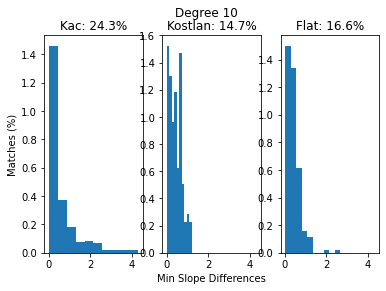

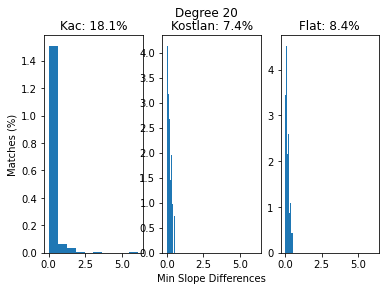

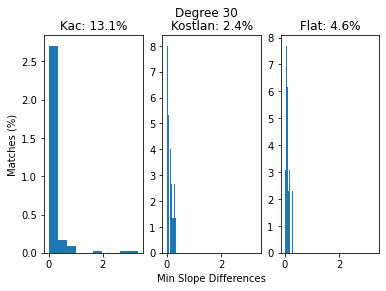

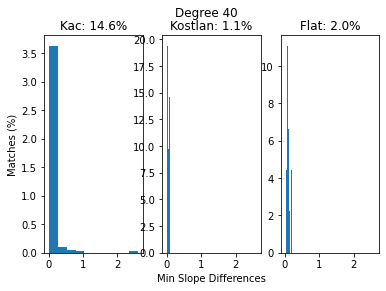

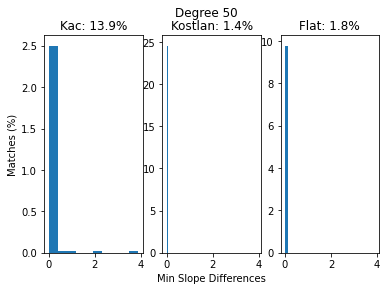

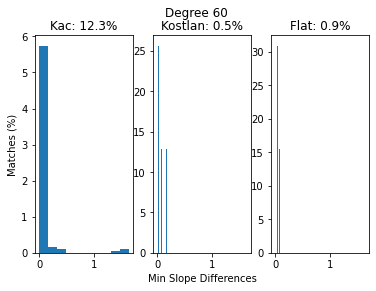

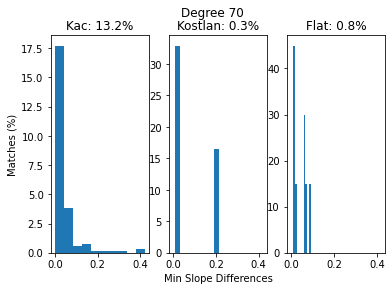

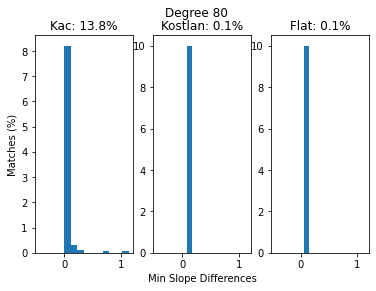

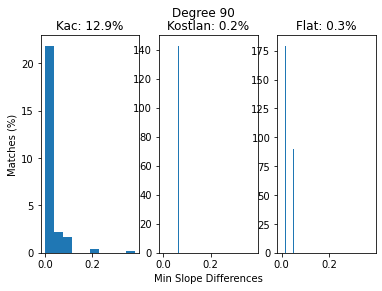

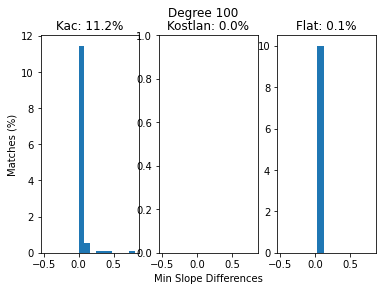

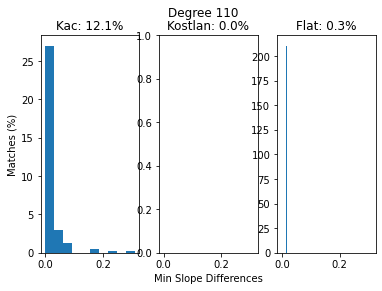

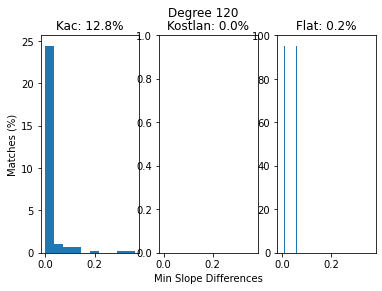

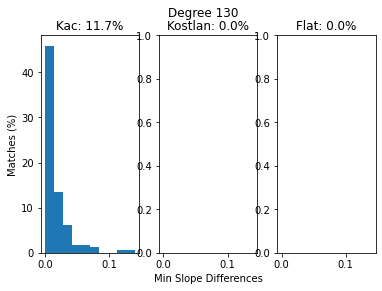

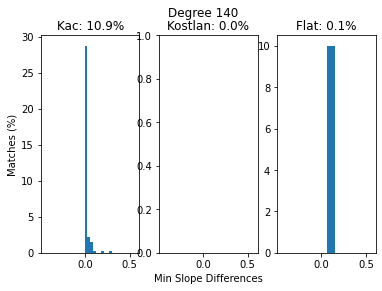

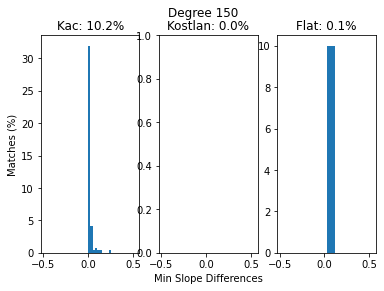

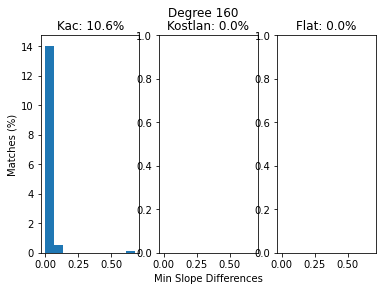

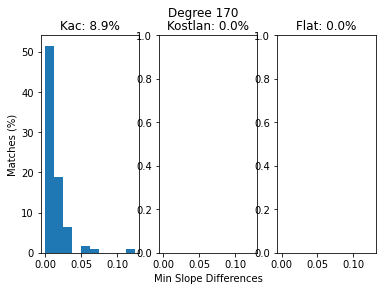

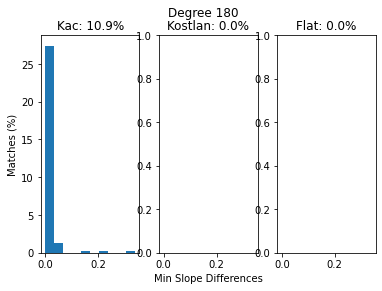

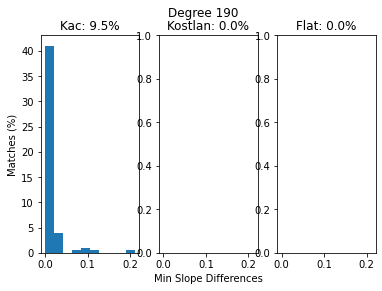

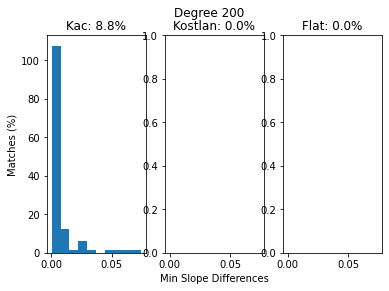

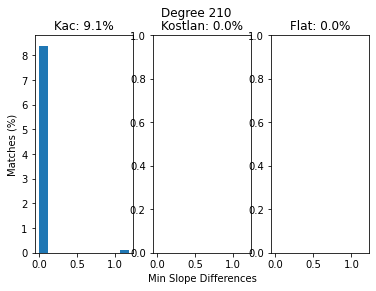

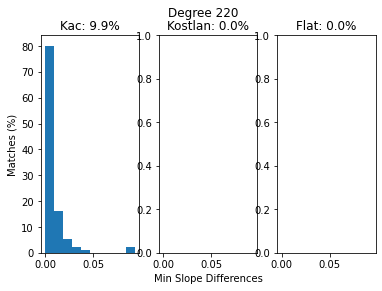

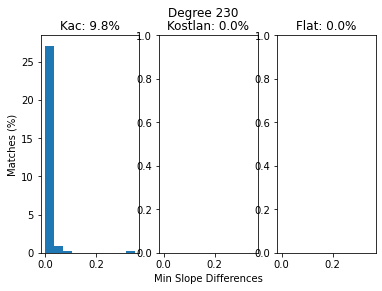

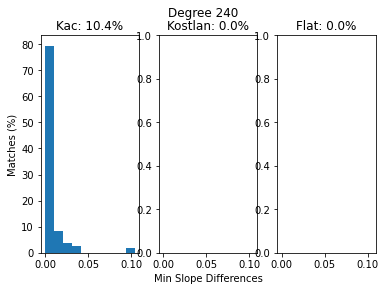

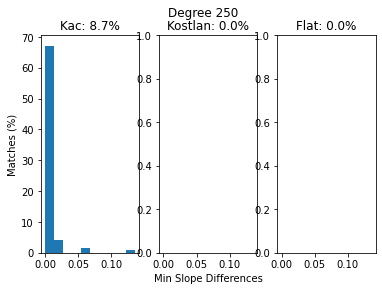

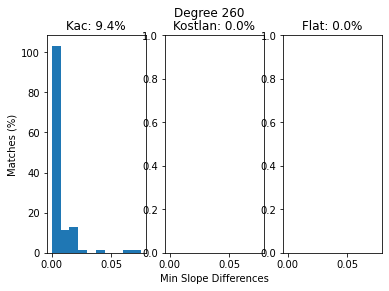

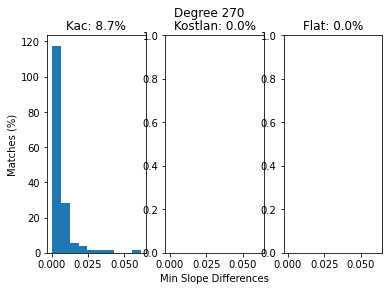

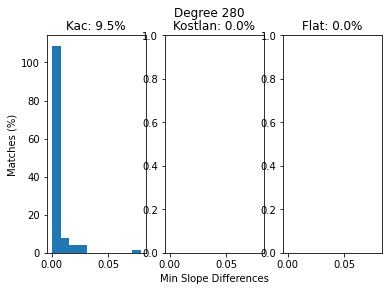

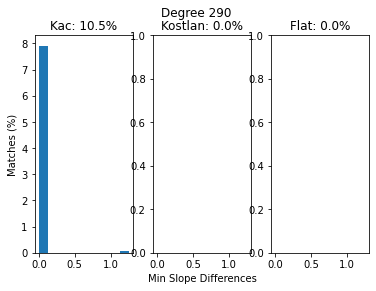

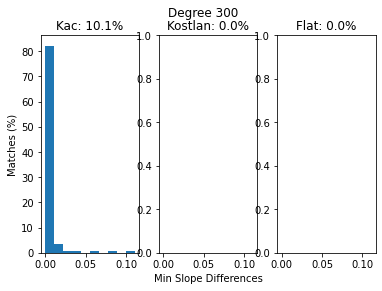

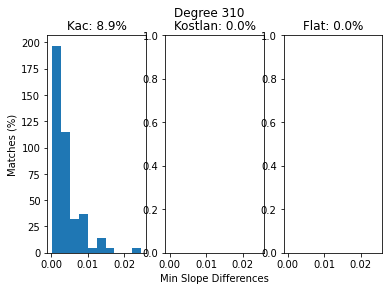

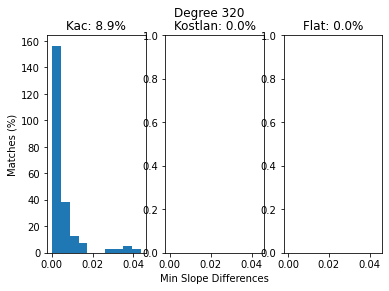

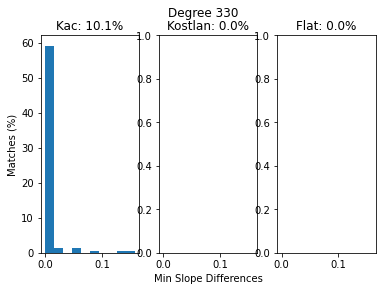

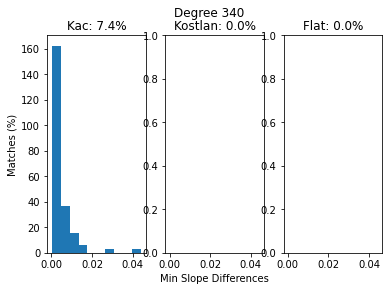

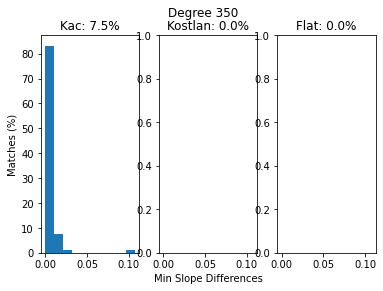

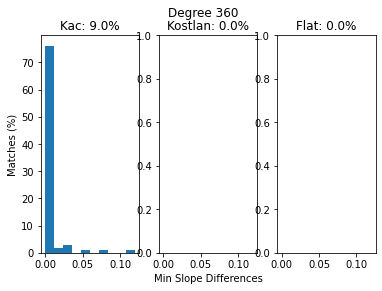

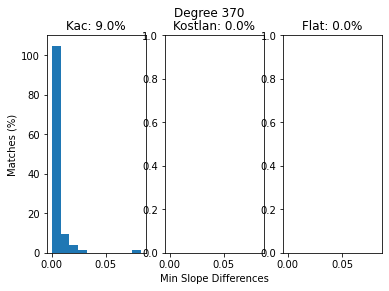

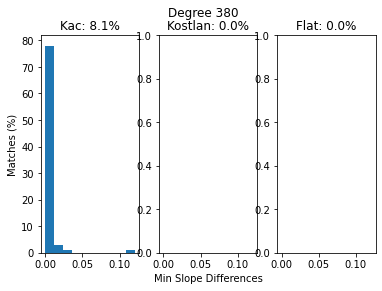

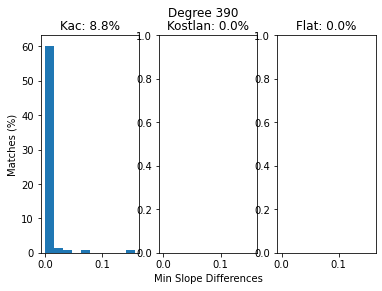

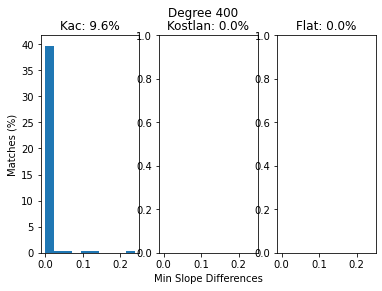

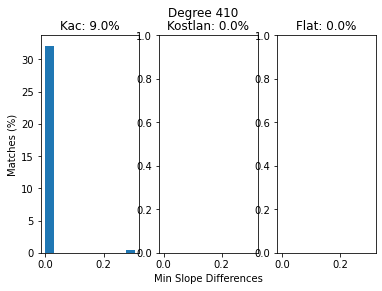

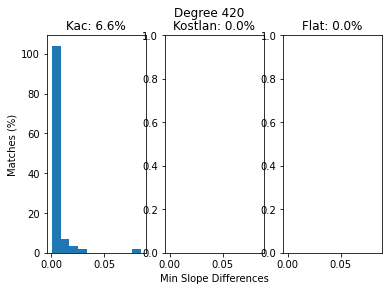

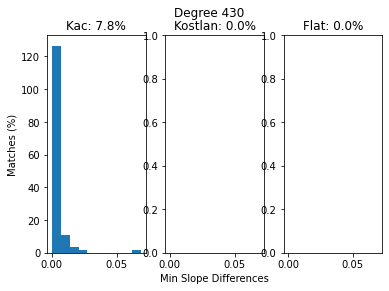

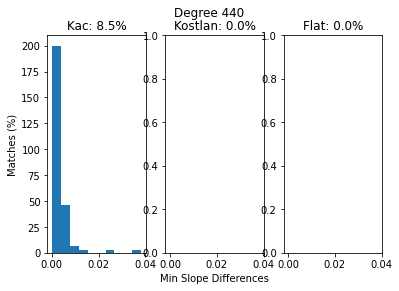

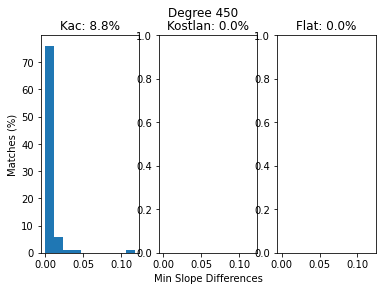

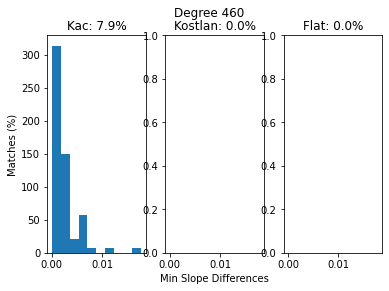

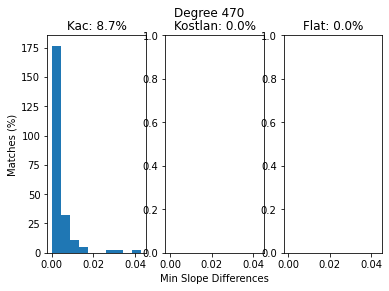

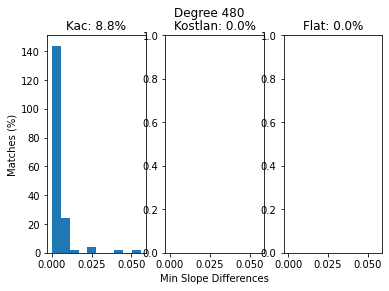

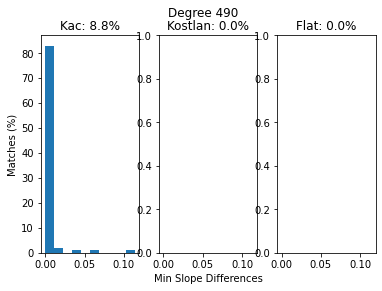

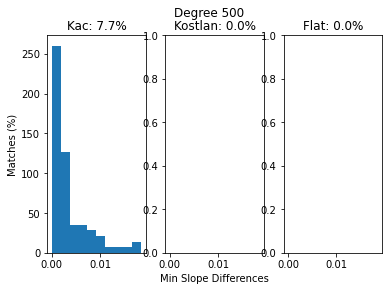

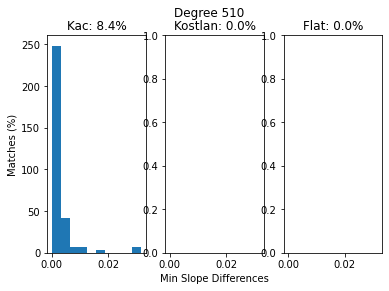

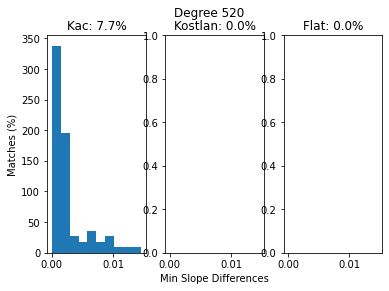

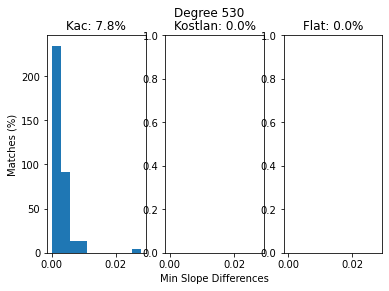

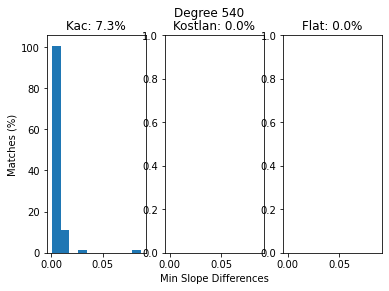

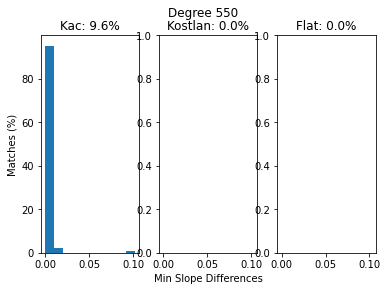

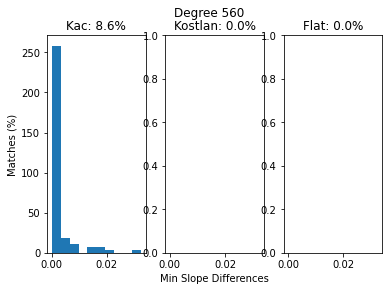

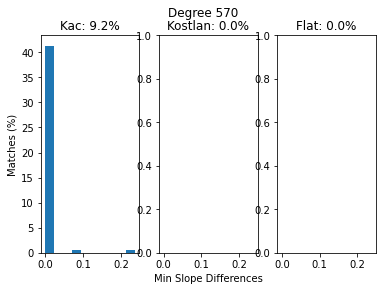

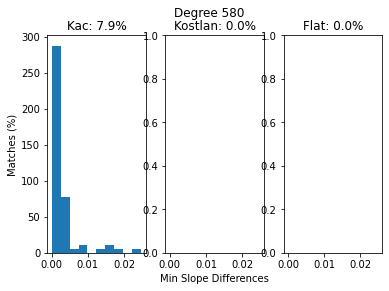

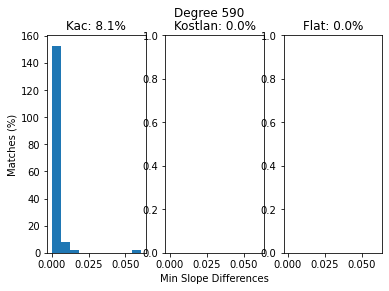

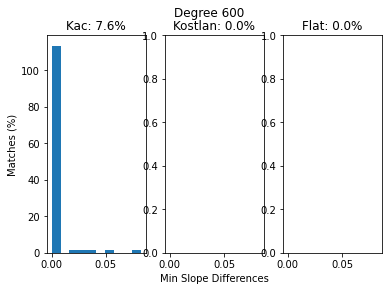

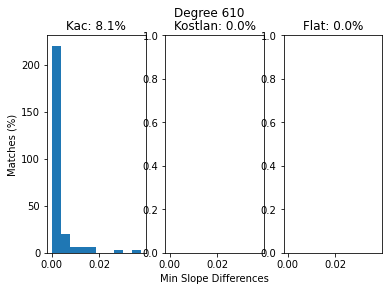

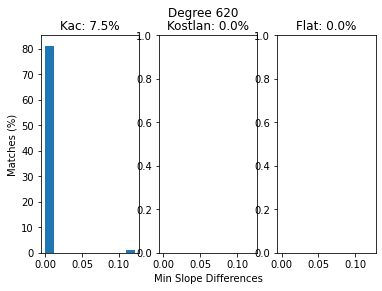

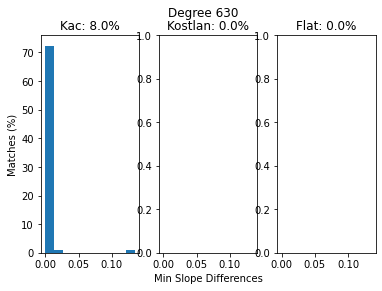

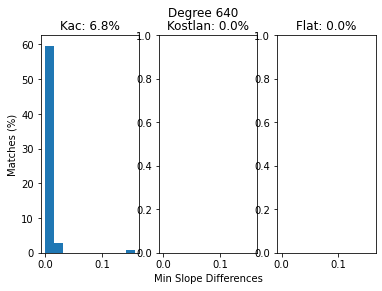

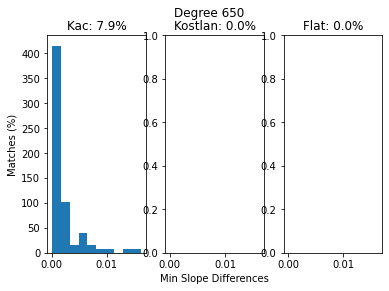

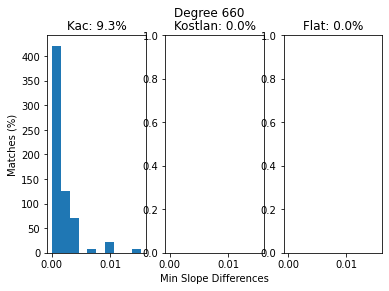

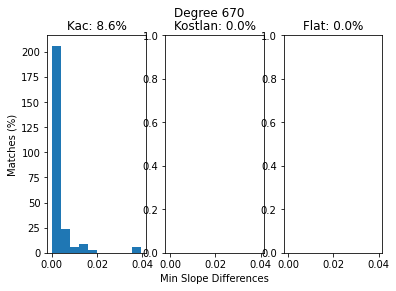

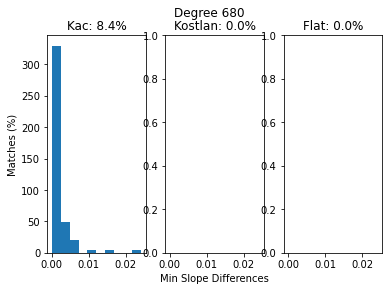

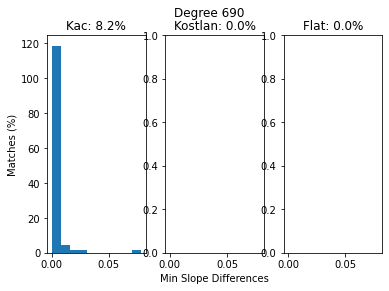

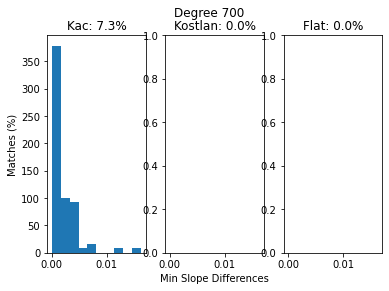

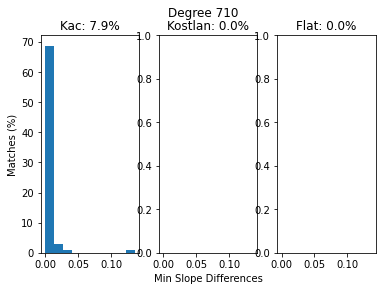

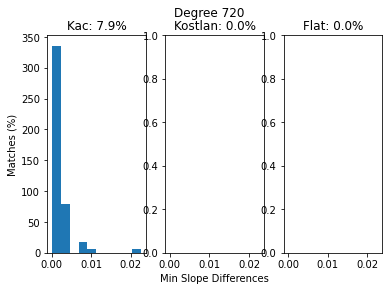

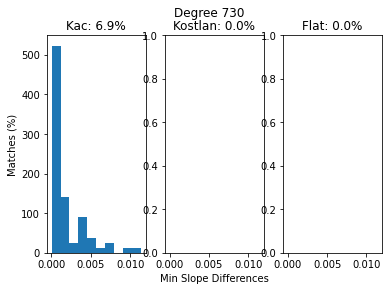

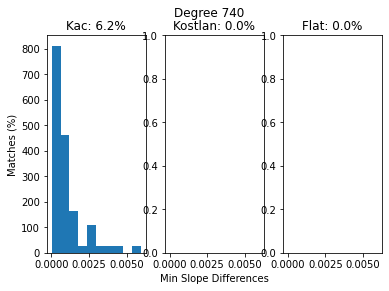

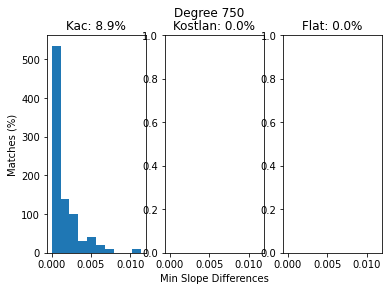

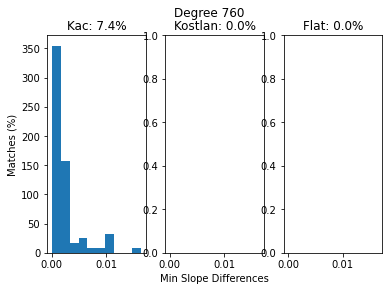

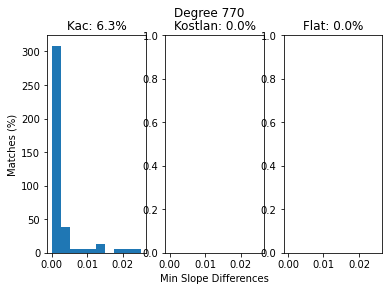

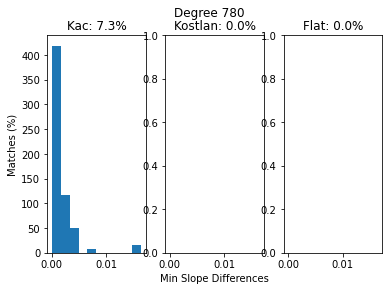

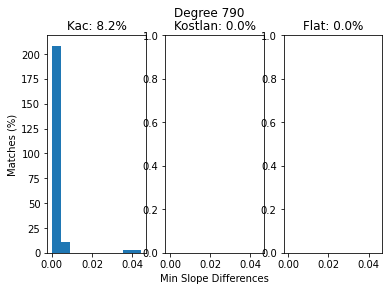

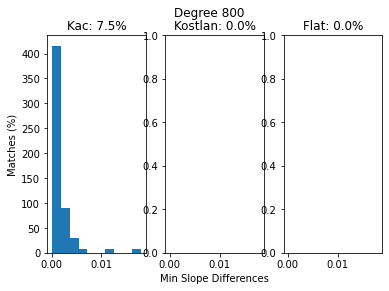

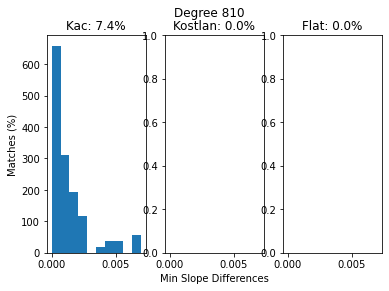

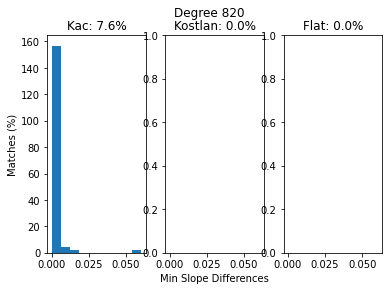

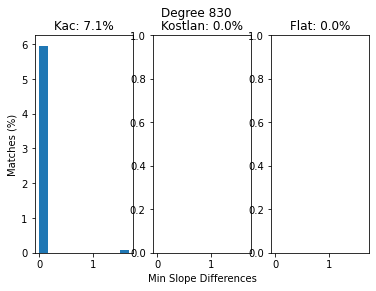

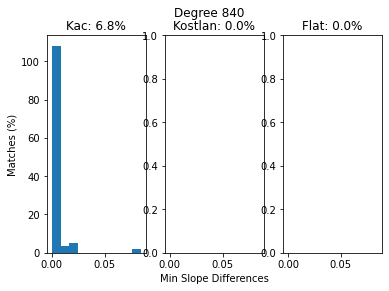

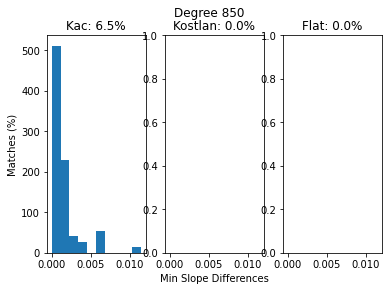

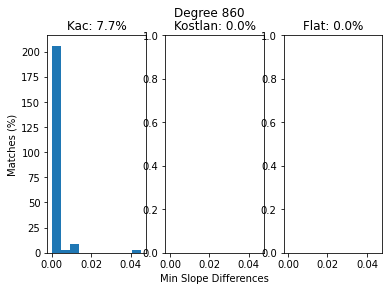

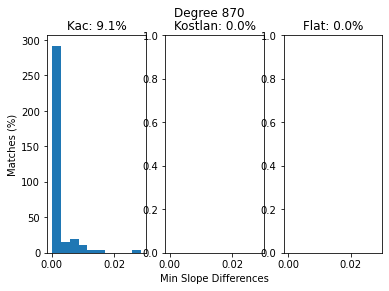

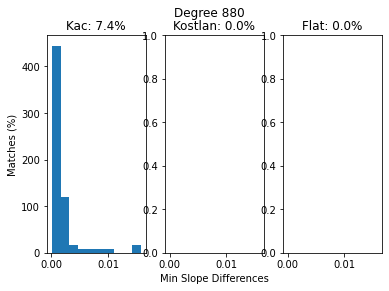

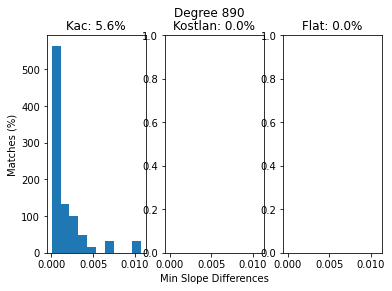

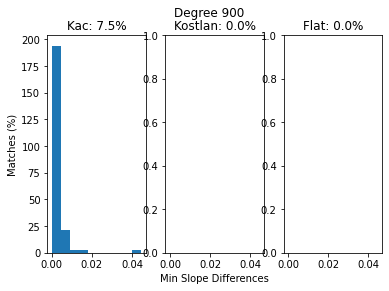

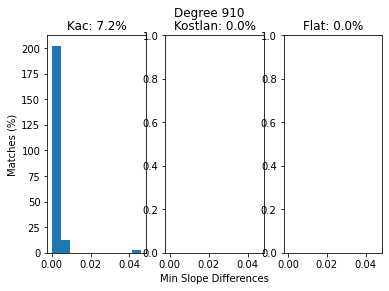

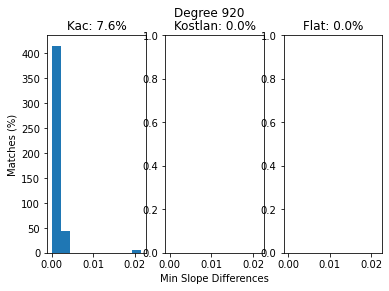

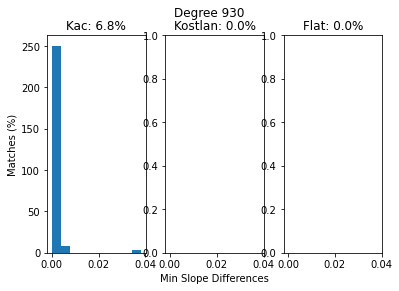

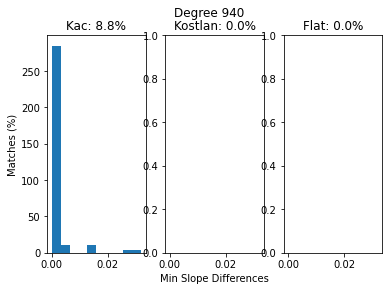

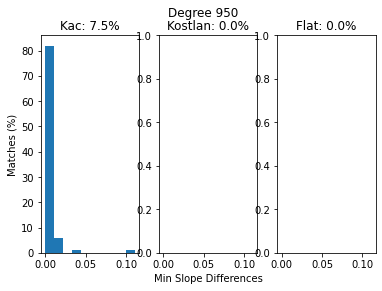

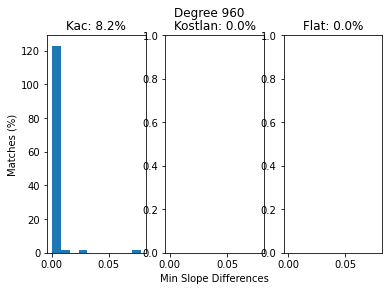

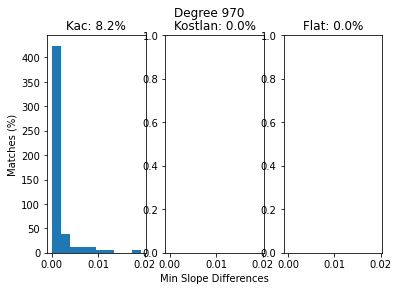

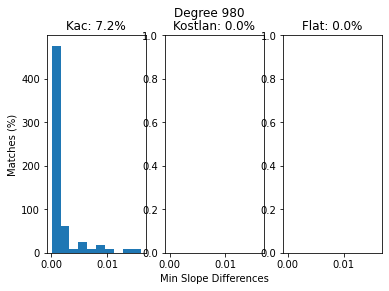

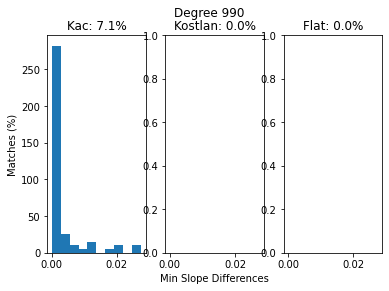

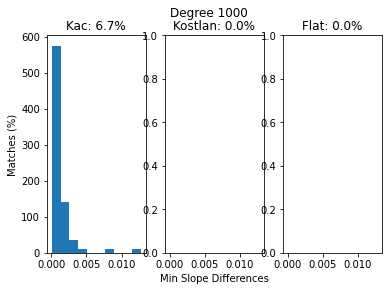

In [ ]:
for d in degrees:
    fig, axes = plt.subplots(1, 3, sharey=False, sharex=True)

    slope_diffs, percent = Verify_Polynomials(d, entries, Kac)
    vals = slope_diffs.values()
    if len(vals) != 0:
        axes[0].hist(vals, density=True)
    axes[0].set_title("Kac: {:.1f}%".format(percent*100))
    axes[0].set_ylabel("Matches (%)")

    slope_diffs, percent = Verify_Polynomials(d, entries, Kostlan)
    vals = slope_diffs.values()
    if len(vals) != 0:
        axes[1].hist(vals, density=True)
    axes[1].set_title("Kostlan: {:.1f}%".format(percent*100))
    axes[1].set_xlabel("Min Slope Differences")

    slope_diffs, percent = Verify_Polynomials(d, entries, Flat)
    vals = slope_diffs.values()
    if len(vals) != 0:
        axes[2].hist(vals, density=True)
    axes[2].set_title("Flat: {:.1f}%".format(percent*100))

    fig.suptitle("Degree " + str(d))
    plt.show()

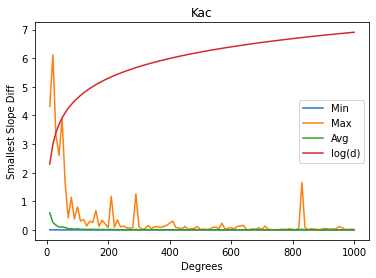

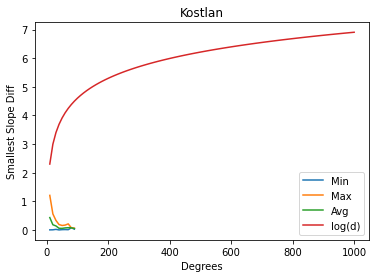

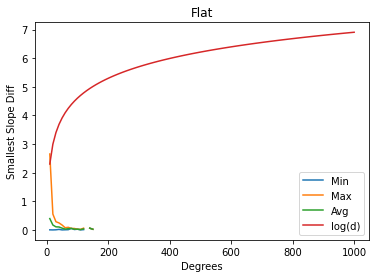

In [ ]:
def Test(func):
    mins = []
    maxs = []
    avgs = []
    for d in degrees:
        valids, percents = Verify_Polynomials(d, entries, func)
        if len(valids.values()) > 0:
            smallest_slope_diff = min(valids.values())
            largest_slope_diff = max(valids.values())
            average_slope_diff = sum(valids.values()) / len(valids)
        else:
            smallest_slope_diff = np.NAN
            largest_slope_diff = np.NAN
            average_slope_diff = np.NAN

        mins.append(smallest_slope_diff)
        maxs.append(largest_slope_diff)
        avgs.append(average_slope_diff)

    plt.plot(degrees, mins, label="Min")
    plt.plot(degrees, maxs, label="Max")
    plt.plot(degrees, avgs, label="Avg")
    plt.plot(degrees, np.log(degrees), label="log(d)")
    plt.title(func.__name__)
    plt.legend()
    plt.xlabel("Degrees")
    plt.ylabel("Smallest Slope Diff")
    plt.show()

Test(Kac)
Test(Kostlan)
Test(Flat)

# Part 1: Histogram

In [ ]:
def Ensemble_Histogram(d, entries, rand_func, seed=0):
    data = rand_func(d, entries)

    fig, (h1, h2) = plt.subplots(1,2, sharex=True, sharey=True)
    fig.suptitle(rand_func.__name__ + " Ensemble: Degree " + str(d))
    zeros = Check_File_Exists(csv_filename(rand_func, d, entries, seed, "rh"), (data, rand_func, d, entries, seed), Compute_Both)
    heuristic = zeros["Heuristic"].values.tolist()
    correct = zeros["Real"].values.tolist()

    bins = len(np.unique(heuristic))
    h1.hist(heuristic, bins, density=True)
    h1.set_title("Heuristic")
    h1.set(xlabel="Num Real Zeros", ylabel="Density")

    bins = len(np.unique(correct))
    h2.hist(correct, bins, density=True)
    h2.set_title("Correct")
    h2.set(xlabel="Num Real Zeros")

    fig.show()

Generating Real Zeros File: Kac_50_1000_0_rh.csv
Generating Real Zeros File: Kac_50_1000_0_r.csv
Generating Real Zeros File: Kac_50_1000_0_h.csv
Generating Real Zeros File: Kostlan_50_1000_0_rh.csv
Generating Real Zeros File: Kostlan_50_1000_0_r.csv
Generating Real Zeros File: Kostlan_50_1000_0_h.csv
Generating Real Zeros File: Flat_50_1000_0_rh.csv
Generating Real Zeros File: Flat_50_1000_0_r.csv
Generating Real Zeros File: Flat_50_1000_0_h.csv


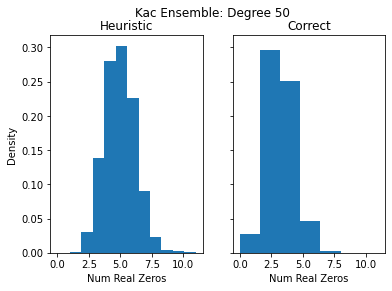

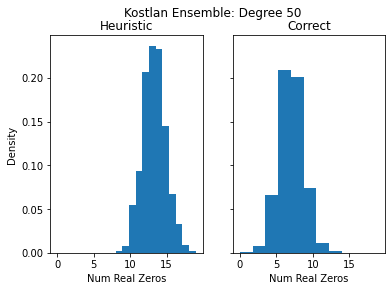

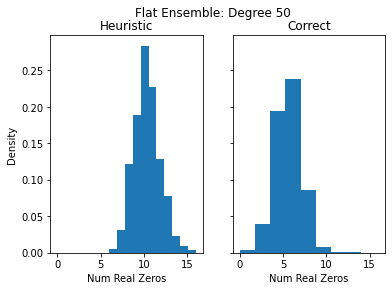

In [ ]:
Ensemble_Histogram(50, entries, Kac)
Ensemble_Histogram(50, entries, Kostlan)
Ensemble_Histogram(50, entries, Flat)

# Part 2: Line Plot

In [ ]:
def Ensemble_Line_Plot(degrees, entries, heur_func, expected_func, correct_approx=None, seed=0):
    expected = [expected_func(d) for d in degrees]
    heuristic = [np.mean(Check_File_Exists(csv_filename(heur_func, d, entries, seed, "h"), heur_func(d, entries), Compute_Heuristic)["0"].to_numpy()) for d in degrees]

    if correct_approx != None:
        correct = [correct_approx(d) for d in degrees]
    else:
        correct = [np.mean(Check_File_Exists(csv_filename(heur_func, d, entries, seed, "r"), heur_func(d, entries), Compute_Correct)["0"].to_numpy()) for d in degrees]

    labels = ["Heuristic", "Correct", "Expected"]
    linestyles = ["solid","solid",(0,(1,5))]
    colors = ["steelblue", "gold", "fuchsia"]
    Plot_Lines(degrees, [heuristic, correct, expected], heur_func.__name__ + " Ensemble", labels, linestyles,colors)

2a) No Approximations. Full computation

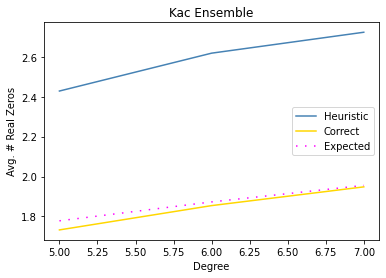

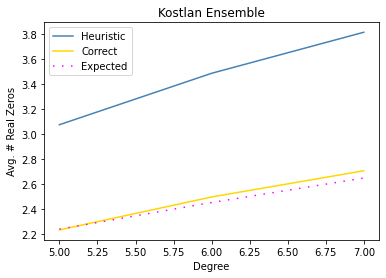

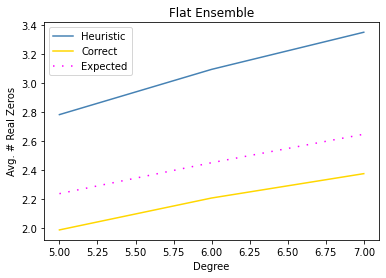

In [ ]:
Ensemble_Line_Plot(degrees, entries, Kac, kac_expected)
Ensemble_Line_Plot(degrees, entries, Kostlan, np.sqrt)
Ensemble_Line_Plot(degrees, entries, Flat, np.sqrt)

2b) Approximate Correct Line (Faster but less accurate)

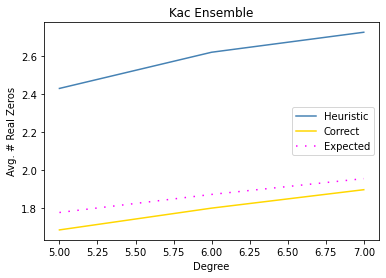

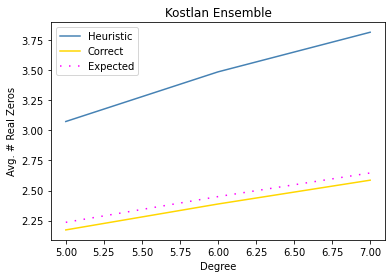

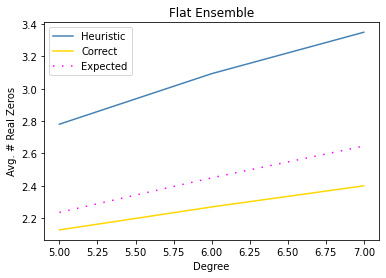

In [ ]:
Ensemble_Line_Plot(degrees, entries, Kac, kac_expected, Kac_Correct_Approx)
Ensemble_Line_Plot(degrees, entries, Kostlan, np.sqrt, Kostlan_Correct_Approx)
Ensemble_Line_Plot(degrees, entries, Flat, np.sqrt, Flat_Correct_Approx)

# Bulk Heuristic

In [ ]:
def Heuristic_Bulk_Plot(degrees, entries, heur_func, expected_func, seeds=[0]):
    expected = [expected_func(d) for d in degrees]
    heuristics = []
    labels = []

    i = 1
    for seed in seeds:
        heuristics += [[np.mean(Check_File_Exists(csv_filename(heur_func, d, entries, seed, "h"), heur_func(d, entries), Compute_Heuristic)) for d in degrees]]
        labels += ["Heuristic " + str(i)]
        i += 1

    Plot_Lines(degrees, heuristics + [expected], heur_func.__name__ + " Ensemble", labels + ["Expected"])


[2357136044 2546248239 3071714933 3626093760 2588848963]


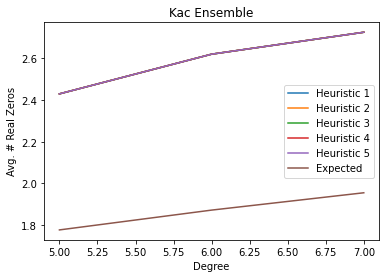

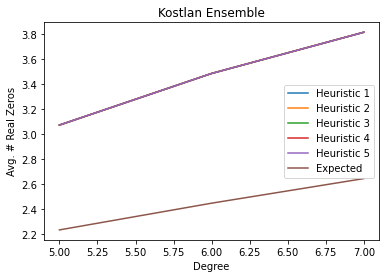

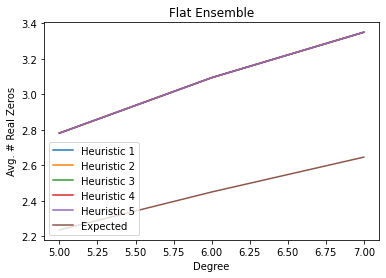

In [ ]:
rng = np.random
rng.seed(0)
seeds = rng.randint(2**10, size=5)
print(seeds)

Heuristic_Bulk_Plot(degrees, entries, Kac, kac_expected, seeds)
Heuristic_Bulk_Plot(degrees, entries, Kostlan, np.sqrt, seeds)
Heuristic_Bulk_Plot(degrees, entries, Flat, np.sqrt, seeds)

# Compute Best Fit Approximations

a) Stack best fit on heuritsic

In [ ]:
def Ensemble_Best_Fit(degrees, entries, heur_func, heur_approx_func, correct_func, expected_func):
    correct = [correct_func(d) for d in degrees]
    expected = [expected_func(d) for d in degrees]
    heuristic = [np.mean(Compute_Heuristic(heur_func(d, entries))) for d in degrees]
    heur_approx = [heur_approx_func(d) for d in degrees]

    labels = ["Heuristic", "Expected", "Correct", "Approx"]
    Plot_Lines(degrees, [heuristic, expected, correct, heur_approx], heur_func.__name__ + " Ensemble", labels)

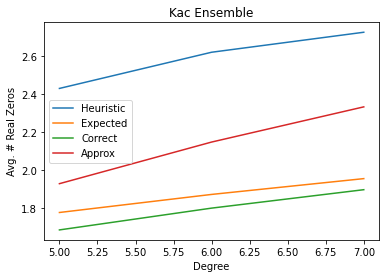

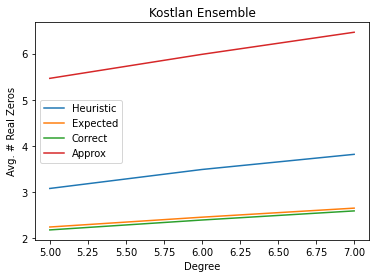

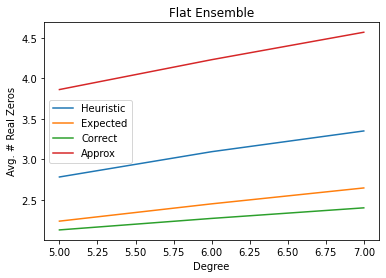

In [ ]:
Ensemble_Best_Fit(degrees, entries, Kac, Kac_Heuristic_Approx, Kac_Correct_Approx, kac_expected)
Ensemble_Best_Fit(degrees, entries, Kostlan, Kostlan_Heuristic_Approx, Kostlan_Correct_Approx, np.sqrt)
Ensemble_Best_Fit(degrees, entries, Flat, Flat_Heuristic_Approx, Flat_Correct_Approx, np.sqrt)

b) Normalize heuristic by best fit

In [ ]:
def Ensemble_Normalized(degrees, entries, heur_func, heur_approx_func, correct_func, expected_func):
    correct = [correct_func(d) for d in degrees]
    expected = [expected_func(d) for d in degrees]
    heuristic = [np.mean(Compute_Heuristic(heur_func(d, entries))) for d in degrees]
    heur_approx = [heur_approx_func(d) for d in degrees]

    heur_normalized = np.array(heuristic) / (np.array(heur_approx) / np.array(expected))

    labels = ["Heuristic", "Expected", "Correct"]
    Plot_Lines(degrees, [heur_normalized, expected, correct], heur_func.__name__ + " Ensemble", labels)

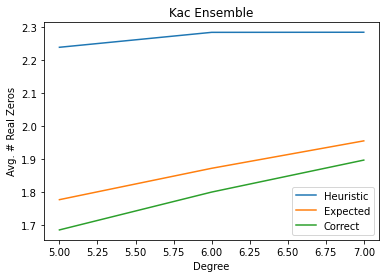

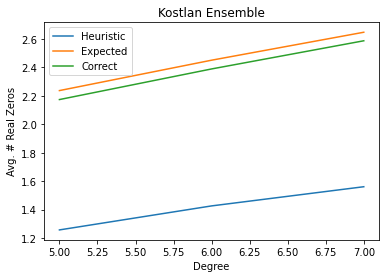

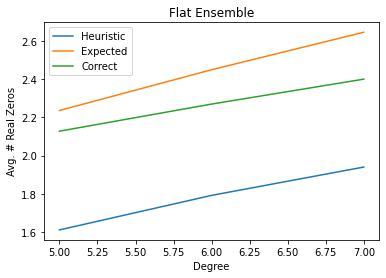

In [ ]:
Ensemble_Normalized(degrees, entries, Kac, Kac_Heuristic_Approx, Kac_Correct_Approx, kac_expected)
Ensemble_Normalized(degrees, entries, Kostlan, Kostlan_Heuristic_Approx, Kostlan_Correct_Approx, np.sqrt)
Ensemble_Normalized(degrees, entries, Flat, Flat_Heuristic_Approx, Flat_Correct_Approx, np.sqrt)

# Compute Best Fit Line (No Need to Run)

In [ ]:
def log(x, a):
    return a * np.log(x)

def sqrt(x, a):
    return a * np.sqrt(x)

def real_best_fit(real_func, approx_func, degrees):
    x = degrees
    y = []

    for d in degrees:
        real_filename = real_func.__name__ + str(d) + ".csv"
        file_entries = Check_Correct_Zeros_File(real_filename, None)
        y += [np.mean(file_entries)]

    popt, pcov = curve_fit(approx_func, x, y)

    plt.scatter(x, y)
    plt.plot(x, approx_func(x, *popt), color="orange")
    plt.show()

    print(popt)
    return popt

def heuristic_best_fit(func, approx_func, max_degree, entries):
    rng = np.random
    rng.seed(0)
    seeds = rng.randint(2**32, size=5)

    x = []
    y = []
    for s in seeds:
        degrees = rng.randint(4, max_degree, size=50)
        x += degrees.tolist()

        for d in degrees:
            data = func(d, entries, s)
            y += [np.mean(Compute_Heuristic(data))]

    popt, pcov = curve_fit(approx_func, x, y)

    plt.scatter(x, y)
    plt.plot(np.sort(x), approx_func(np.sort(x), *popt), color="orange")
    plt.show()

    print(popt)
    return popt

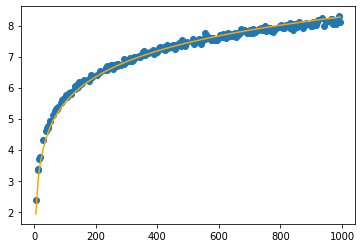

[1.19852464]


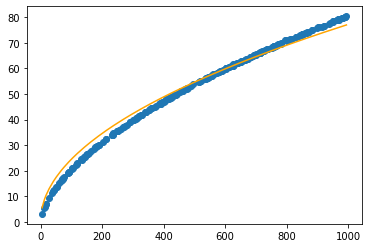

[2.44343852]


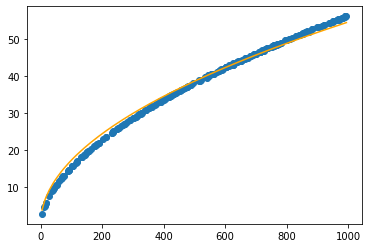

[1.72613493]


array([1.72613493])

In [ ]:
max_degree = 1000
entries = 1000

heuristic_best_fit(Kac, log, max_degree, entries)
heuristic_best_fit(Kostlan, sqrt, max_degree, entries)
heuristic_best_fit(Flat, sqrt, max_degree, entries)

In [ ]:
#DO NOT RUN WITHOUT REAL FILES
kac_params = real_best_fit(Kac, log, degrees)
kostlan_params = real_best_fit(Kostlan, sqrt, degrees)
flat_params = real_best_fit(Flat, sqrt, degrees)

Generating Real Zeros File: Kac5.csv


AttributeError: ignored

# Code Avoiding Loops

In [ ]:
pip install 'fsspec>=0.3.3'

In [ ]:
pip install dask[dataframe] --upgrade

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.special import comb
from scipy.special import factorial
from scipy.integrate import quad
import matplotlib.pyplot as plt
import random
import plotly.graph_objects as go
import itertools
from plotly.subplots import make_subplots
import dask
import dask.dataframe as dd

In [ ]:
def lower_convex_hull_vertices(vec):

    """
    Parameter:

    vec = numeric vector

    Output:

    The operation ConvexHull returns the indices of the points defining the Convex Hull organized counter clockwise. From those, this operation returns the ones in the Lowe Convex hull.
    """

    max_pos = np.where(vec == np.amax(vec))[0][0]
    min_pos = np.where(vec == np.amin(vec))[0][0]
    if min_pos < max_pos:
        return vec[min_pos:max_pos+1]
    else:
        return np.concatenate((vec[min_pos:],vec[:max_pos+1]))

In [ ]:
def crossings_nonzero_all(data):

    """
    Parameter:

    #data: numeric vector

    Output:

    #returns: The vector of indices prior to a sign change.
    """

    pos = data > 0
    npos = ~pos
    return ((pos[:-1] & npos[1:]) | (npos[:-1] & pos[1:])).nonzero()[0]

In [ ]:
def sign_changes(row,num_cols):

    """
    Parameters:

    Output:

    """

    input_data = np.array([list(range(num_cols)), row.values.tolist()]).T

    conv_hull = ConvexHull(input_data).vertices
    lower_conv_hull = list(lower_convex_hull_vertices(conv_hull))
    coefs = row.iloc[lower_conv_hull].values

    S1 = np.sign(coefs)
    S2 = np.array([(-1)**x for x in lower_conv_hull]) * S1

    sign_changes_S1 = len(crossings_nonzero_all(S1))
    sign_changes_S2 = len(crossings_nonzero_all(S2))

    return int(sign_changes_S1 + sign_changes_S2)

In [ ]:
def compute_zeros_dask(degree,sample_size,method,npartitions = 8):

    """
    Parameters:

    Output:

    """

    np.random.seed(0)

    num_cols = degree + 1

    c1 = 2/np.pi
    c2 = 0.6257358072
    c3 = c1/degree
    idx = np.arange(degree+1)

    if method == 'kac':
        mean = 0
        std_dev = 1
        expected_value = c1*np.log(degree) + c2 + c3
    elif method == 'kostlan':
        mean = 0
        std_dev = comb(degree, idx)
        expected_value = np.sqrt(degree)
#    elif method == 'flat':
#        mean = 0
#        std_dev = 1/(factorial(idx))
#        expected_value = np.sqrt(degree)
    else:
        raise Exception('The chosen method is not among the possible ones. Please, choose between kac (Kac Emsenble), kostlan (Kostlan/Ellipsoid Ensemble), or klat (Flat ensemble).')

    df = pd.DataFrame(-np.log(np.abs(std_dev * (mean + np.random.randn(sample_size,num_cols)))))
    df = dd.from_pandas(df, npartitions = npartitions)

    vector = df.apply(lambda row: sign_changes(row,num_cols),axis = 1,meta=(None, 'int64'))

    zeros = vector.compute()

    normalized_zeros = zeros.value_counts(normalize = True).sort_index()

   # print("Method: " + str(method))
   #
   # print("Expected Value = " + str(expected_value) + ".")
   #
   # print("Average Number of Zeros = " + str(zeros.mean()) + ".")

    return normalized_zeros

In [ ]:
%%time
compute_zeros_dask(1000, 1000, 'kac')

In [ ]:
def real_zeros_charts_dask(degree, sample_size):

    """
    Parameters:

    Output:

    """

    result_1 = compute_zeros_dask(degree, sample_size, 'kac')
    result_2 = compute_zeros_dask(degree, sample_size, 'kostlan')
#    result_3 = compute_zeros_dask(degree, sample_size, 'flat')

    fig = make_subplots(
        rows=1, cols=2, subplot_titles=("Kac Ensemble", "Kostlan Ensemble",
                                        #"Flat Ensemble"
                                       )
    )

    # Add traces
    fig.add_trace(go.Bar(x=result_1.index, y=result_1, marker_color = "steelblue"), row=1, col=1)
    fig.add_trace(go.Bar(x=result_2.index, y=result_2, marker_color = "steelblue"), row=1, col=2)
    #fig.add_trace(go.Bar(x=result_3.index, y=result_3, marker_color = "steelblue"), row=1, col=3)

    # Update xaxis properties
    fig.update_xaxes(title_text="Number of Real Zeros", showgrid=False, row=1, col=1)
    fig.update_xaxes(title_text="Number of Real Zeros", showgrid=False, row=1, col=2)
    #fig.update_xaxes(title_text="Number of Real Zeros", showgrid=False, row=1, col=3)

    ## Update yaxis properties
    #fig.update_yaxes(title_text=False, row=1, col=1)
    #fig.update_yaxes(title_text=False, row=1, col=2)
    #fig.update_yaxes(title_text=False, row=1, col=3)

    # Update title and height
    fig.update_layout(showlegend=False,title_text="Heuristic Distribution of Real Zeros")

    fig.show()

In [ ]:
%%time
real_zeros_charts_dask(1000,1000)

In [ ]:
def real_zeros_convergence_dask(a, b, step, sample_size):

    """
    Parameters:

    a: Int. Degree lower bound.
    b: Int. Degree upper bound.
    step: Int. Number specifying the incrementation.
    sample_size: Int. Number of polynomials to consider.

    Output:

    """

    c1 = 2/np.pi
    c2 = 0.6257358072

    degrees = list(range(a,b,step))

    diff_1 = []
    diff_2 = []
#    diff_3 = []

    for degree in degrees:

        result_1 = compute_zeros_dask(degree, sample_size, 'kac')
        result_2 = compute_zeros_dask(degree, sample_size, 'kostlan')
#        result_3 = compute_zeros_dask(degree, sample_size, 'flat')

        mean_value_1 = np.sum(np.array(result_1.index) * result_1.values)
        mean_value_2 = np.sum(np.array(result_2.index) * result_2.values)
#        mean_value_3 = np.sum(np.array(result_3.index) * result_3.values)

        c3 = c1/degree

        theoretical_expected_value_1 = c1*np.log(degree) + c2 + c3
        diff_1.append(abs(theoretical_expected_value_1 - mean_value_1))

        theoretical_expected_value_2 = np.sqrt(degree)
        diff_2.append(abs(theoretical_expected_value_2 - mean_value_2))
#        diff_3.append(abs(theoretical_expected_value_2 - mean_value_3))

    fig = make_subplots(
        rows=1, cols=2, subplot_titles=("Kac Ensemble", "Kostlan Ensemble",
                                        #"Flat Ensemble"
                                       )
    )

    # Add traces
    fig.add_trace(go.Scatter(x=degrees, y=diff_1, marker_color = "steelblue"), row=1, col=1)
    fig.add_trace(go.Scatter(x=degrees, y=diff_2, marker_color = "steelblue"), row=1, col=2)
    #fig.add_trace(go.Scatter(x=degrees, y=diff_3, marker_color = "steelblue"), row=1, col=3)

    # Update xaxis properties
    fig.update_xaxes(title_text="Number of Real Zeros", showgrid=False, row=1, col=1)
    fig.update_xaxes(title_text="Degrees", showgrid=False, row=1, col=2)
    #fig.update_xaxes(title_text="Number of Real Zeros", showgrid=False, row=1, col=3)

    ## Update yaxis properties
    #fig.update_yaxes(title_text=False, row=1, col=1)
    #fig.update_yaxes(title_text=False, row=1, col=2)
    #fig.update_yaxes(title_text=False, row=1, col=3)

    # Update title and height
    fig.update_layout(showlegend=False,title_text="Convergence of the Sample Mean to the Theoretical Expected Value")

    fig.show()

In [ ]:
real_zeros_convergence_dask(100, 1000, 100, 500)

In [ ]:
def compute_zeros_dask_kac(degree,sample_size,npartitions = 8):

    """
    Parameters:

    Output:

    """

    np.random.seed(0)

    num_cols = degree + 1

    c1 = 2/np.pi
    c2 = 0.6257358072
    c3 = c1/degree
    idx = np.arange(degree+1)
    mean = 0
    std_dev = 1
    expected_value = c1*np.log(degree) + c2 + c3

    df = pd.DataFrame(-np.log(np.abs(std_dev * (mean + np.random.randn(sample_size,num_cols)))))
    df = dd.from_pandas(df, npartitions = npartitions)

    vector = df.apply(lambda row: sign_changes(row,num_cols),axis = 1,meta=(None, 'int64'))

    zeros = vector.compute()

    normalized_zeros = zeros.value_counts(normalize = True).sort_index()

   # print("Method: " + str(method))
   #
   # print("Expected Value = " + str(expected_value) + ".")
   #
   # print("Average Number of Zeros = " + str(zeros.mean()) + ".")

    return normalized_zeros

In [ ]:
%%time
zeros_distribution = compute_zeros_dask_kac(100000,1000,npartitions = 8)

In [ ]:
def real_zeros_charts_dask_kac(degree, sample_size):

    """
    Parameters:

    Output:

    """

    result_1 = compute_zeros_dask(degree, sample_size, 'kac')

    fig = make_subplots(
        rows=1, cols=1, subplot_titles=("Kac Ensemble", "Kostlan Ensemble",
                                        #"Flat Ensemble"
                                       )
    )

    # Add traces
    fig.add_trace(go.Bar(x=result_1.index, y=result_1, marker_color = "steelblue"), row=1, col=1)

    # Update xaxis properties
    fig.update_xaxes(title_text="Number of Real Zeros", showgrid=False, row=1, col=1)

    ## Update yaxis properties
    #fig.update_yaxes(title_text=False, row=1, col=1)

    # Update title and height
    fig.update_layout(showlegend=False,title_text="Heuristic Distribution of Real Zeros")

    fig.show()

In [ ]:
%%time
real_zeros_charts_dask_kac(100000,1000)

In [ ]:
def real_zeros_convergence_dask_kac(a, b, step, sample_size):

    """
    Parameters:

    a: Int. Degree lower bound.
    b: Int. Degree upper bound.
    step: Int. Number specifying the incrementation.
    sample_size: Int. Number of polynomials to consider.

    Output:

    """

    c1 = 2/np.pi
    c2 = 0.6257358072

    degrees = list(range(a,b,step))

    diff_1 = []

    for degree in degrees:

        result_1 = compute_zeros_dask(degree, sample_size, 'kac')

        mean_value_1 = np.sum(np.array(result_1.index) * result_1.values)

        c3 = c1/degree

        theoretical_expected_value_1 = c1*np.log(degree) + c2 + c3
        diff_1.append(abs(theoretical_expected_value_1 - mean_value_1))

    fig = make_subplots(
        rows=1, cols=1, subplot_titles=("Kac Ensemble" )
    )

    # Add traces
    fig.add_trace(go.Scatter(x=degrees, y=diff_1, marker_color = "steelblue"), row=1, col=1)

    # Update xaxis properties
    fig.update_xaxes(title_text="Number of Real Zeros", showgrid=False, row=1, col=1)

    ## Update yaxis properties
    #fig.update_yaxes(title_text=False, row=1, col=1)

    # Update title and height
    fig.update_layout(showlegend=False,title_text="Convergence of the Sample Mean to the Theoretical Expected Value")

    fig.show()

In [ ]:
real_zeros_convergence_dask(1000, 100000, 1000, 1000)